In [82]:
import pandas as pd
import numpy as np

In [178]:
sim_id = 0
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
            
#filename = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'
filename = '../data/featuresfromshortruns/output'+str(sim_id)+'.csv'
run = pd.read_csv(filename, names=columns)
run.head()

,Time,Lyapunov Time,a1,P1,e1,pomega1,inc1,Omega1,f1,a2,...,inc2,Omega2,f2,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0.000000,inf,0.056881,0.013566,0.005216,-3.088293,0.007068,-1.358398,1.923325,0.066725,...,0.015850,-3.112129,1.779466,0.076334,0.021090,0.015063,-2.398046,0.004372,-0.567135,-0.107999
1,0.067863,-0.503330,0.056914,0.013578,0.005973,-2.847616,0.007138,-1.367602,1.699237,0.066739,...,0.015803,-3.118137,1.444774,0.076279,0.021067,0.014250,-2.437014,0.004385,-0.570110,1.333740
2,0.135726,-0.688529,0.056876,0.013564,0.005950,-3.072441,0.007167,-1.368827,1.935987,0.066739,...,0.015823,-3.122376,0.865252,0.076322,0.021085,0.012731,-2.437054,0.004423,-0.574628,2.696141
3,0.203589,-1.029903,0.056873,0.013563,0.004775,-2.942920,0.007202,-1.375138,1.821911,0.066740,...,0.015817,-3.129253,0.642454,0.076327,0.021087,0.015158,-2.419583,0.004482,-0.583294,4.020210
4,0.271452,-1.438369,0.056876,0.013564,0.006413,-2.812365,0.007249,-1.376436,1.711192,0.066738,...,0.015846,-3.136356,0.131849,0.076323,0.021085,0.012801,-2.473977,0.004541,-0.591500,-0.827657


In [179]:
def avg(feature): # pass string for feature, e.g., 'a1' and returns a function that returns the average of that feature
    def avg_feat():
        return run[feature].mean()
    avg_feat.__name__ = 'avg_'+feature
    return avg_feat

def std(feature): # returns function that returns standard deviation of feature
    def std_feat():
        return run[feature].std()
    std_feat.__name__ = 'std_'+feature
    return std_feat

def maximum(feature): # returns function that returns maximum 
    def max_feat():
        return run[feature].max()
    max_feat.__name__ = 'max_'+feature
    return max_feat

def minimum(feature): # returns function that returns minimum
    def min_feat():
        return run[feature].min()
    min_feat.__name__ = 'min_'+feature
    return min_feat

def norm_std(feature): # returns function that returns standard deviation of feature, normalized to the mean of the feature
    def norm_std_feat():
        return run[feature].std()/run[feature].mean()
    norm_std_feat.__name__ = 'norm_std_'+feature
    return norm_std_feat

def norm_maximum(feature): # returns function that returns absolute value of maximum deviation from mean, normalized to mean
    def norm_max_feat():
        return np.abs(run[feature] - run[feature].mean()).max()/run[feature].mean()
    norm_max_feat.__name__ = 'norm_max_'+feature
    return norm_max_feat

def norm_std_window(feature, Nsamples): # returns function that returns standard deviation of feature, normalized to the mean of the feature, only taking the first Nsamples
    def norm_std_window_feat():
        sample = run[feature][:Nsamples]
        return sample.std()/sample.mean()
    norm_std_window_feat.__name__ = 'norm_std_window'+str(Nsamples)+'_'+feature
    return norm_std_window_feat

def norm_maximum_window(feature, Nsamples): # returns function that returns absolute value of maximum deviation from mean, normalized to mean, only taking the first Nsamples
    def norm_max_window_feat():
        sample = run[feature][:Nsamples]
        return np.abs(sample - sample.mean()).max()/sample.mean()
    norm_max_window_feat.__name__ = 'norm_max_window'+str(Nsamples)+'_'+feature
    return norm_max_window_feat

def norm_LyapunovTime(): # returns last value for the Lyapunov time, normalized to inner (initial) orbital period
    length = run['Lyapunov Time'].shape[0]
    return run['Lyapunov Time'][length-1]/run['P1'][0]

def norm_drift_window(feature, Nsamples): # returns function that returns the drift between the first and last window
    def norm_drift_window_feat():
        return np.abs(run[feature][0:Nsamples].median() - run[feature][-Nsamples:].median())/run[feature].median()
    norm_drift_window_feat.__name__ = 'norm_max_window'+str(Nsamples)+'_'+feature
    return norm_drift_window_feat

In [397]:
def get_var(data,i,var):
    i = str(i)
    if var == "Lyapunov Time":
        return data[var].values[1:]
    if var == "z":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.exp(pomega*1j)
    if var == "h":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.cos(pomega)
    if var == "k":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.sin(pomega)
    if var == "dpomega":
        i = int(i)
        return data["pomega"+str(i)].values - data["pomega"+str(i-1)].values
    else:
        return data[var+i].values

def fourier(data,var):
    fig, ax = plt.subplots(2, figsize=(8,6))
    plt.subplots_adjust(hspace=0.4)
    
    t=data["Time"].values
    if var == "Lyapunov Time":
        t = t[1:]
    tmax = round(t[-1])
    N_outputs = len(t)
    window = np.hanning(N_outputs)
    Period = 1./np.fft.fftfreq(N_outputs, tmax/N_outputs) 
    power_ratio = 0
    for i in range(1,4):
        y = get_var(data,i,var)
        power = np.absolute(np.fft.fft(y)/N_outputs)
        OP1 = Period/data["P1"][0]                      #normalize to orbital period of inner planet
        power = power[(OP1>0)&(OP1<float('inf'))]
        OP1 = OP1[(OP1>0)&(OP1<float('inf'))]
        #boundaryOP1 = 10**(max(np.log10(OP1))/2)        #boundary is even split in log space
        bound1 = 30
        bound2 = 1000
        power_ratio = max(sum(power[(OP1>=bound1)&(OP1<bound2)])/sum(power[OP1<bound1]),power_ratio) #ratio of power[OP1>boundaryOP1]/power[OP1<boundaryOP1]
        ax[0].plot(OP1,power,label='Planet %d'%i)
        ax[1].plot(t,y,label='Planet %d'%i)
        #ax[1].plot(t,y/np.median(y) + 1e-3*i,label='Planet %d'%i)
        
    ax[0].set_ylabel("power of: "+var, fontsize=13)
    ax[0].set_xlabel('Orbital Period of Planet 1', fontsize=13)
    ax[0].set_xscale('log')
    ax[0].legend(loc='upper right',fontsize=8)
    ax[0].set_yscale('log')
    ax[0].set_xlim([10,1e4])
    ax[1].set_ylabel(var, fontsize=13)
    ax[1].set_xlabel('time', fontsize=13)
    plt.show()
    print("For variable:'%s', The max ratio of Power[%.1e>Period>=%.1e]/[Period<%.1e]=%f"%(var,bound2,bound1,bound1,power_ratio))
    return power_ratio

def feature_slope(data,feature):
    xx = range(data.shape[0])
    yy = data[feature]/data[feature].mean()/data["Time"].iloc[-1]
    par = np.polyfit(xx, yy, 1, full=True)
    slope, intercept = par[0][0], par[0][1]
    plt.plot(xx,yy, '.')
    plt.plot(xx,[slope*x + intercept for x in xx], linewidth=5)
    print "%s has slope=%e"%(feature,slope)
    return slope

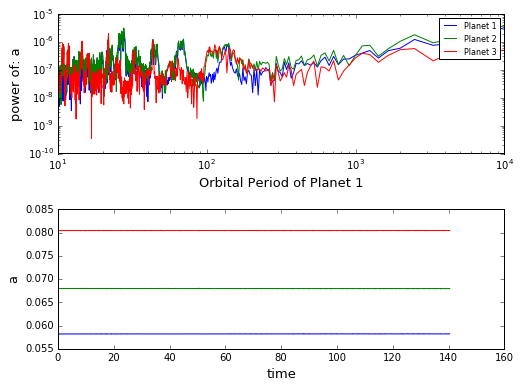

For variable:'a', The max ratio of Power[1.0e+03>Period>=3.0e+01]/[Period<3.0e+01]=0.522314
a1 has slope=1.140452e-09
a2 has slope=-1.209919e-09
a3 has slope=1.659348e-10


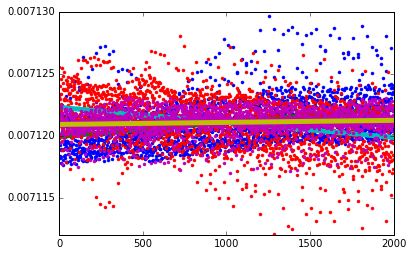

In [398]:
#ids labelled as stable but unstable: 4002, 1777, 4404, 2487, 4680
#ids correct: 1229, 1644, 759, 1515, 4470
import matplotlib.pyplot as plt
%matplotlib inline

sim_id = 4002
var = "a"

filename = '../data/featuresfromshortruns/output'+str(sim_id)+'.csv'
#filename = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'
run = pd.read_csv(filename, names=columns)
fourier(run,var)

for i in range(1,4):
    feature_slope(run,"a"+str(i))

#Nsamples=50
#for i in range(1,4):
#    drift_window(run,'a'+str(i),Nsamples)
    
#score = []
#for N in np.logspace(0,3,50):
#    N = int(N)
#    score.append(drift_window(run,"a2",N))
#plt.plot(score)

In [183]:
featurelist = []
for f in ['a1', 'a2', 'a3', 'e1', 'e2', 'e3']:
    featurelist.append(avg(f))
    featurelist.append(std(f))
    featurelist.append(maximum(f))
    featurelist.append(minimum(f))
    featurelist.append(norm_std(f))
    featurelist.append(norm_maximum(f))
    featurelist.append(norm_std_window(f, 10))
    featurelist.append(norm_maximum_window(f, 10))
    featurelist.append(norm_drift_window(f, 10))   #drift window (i.e. mean value at end of run vs. beginning)
featurenames = [f.__name__ for f in featurelist]
print("Features that will be added = {0}".format(featurenames))


Features that will be added = ['avg_a1', 'std_a1', 'max_a1', 'min_a1', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1', 'norm_max_window10_a1', 'avg_a2', 'std_a2', 'max_a2', 'min_a2', 'norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'norm_max_window10_a2', 'avg_a3', 'std_a3', 'max_a3', 'min_a3', 'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 'norm_max_window10_a3', 'avg_e1', 'std_e1', 'max_e1', 'min_e1', 'norm_std_e1', 'norm_max_e1', 'norm_std_window10_e1', 'norm_max_window10_e1', 'norm_max_window10_e1', 'avg_e2', 'std_e2', 'max_e2', 'min_e2', 'norm_std_e2', 'norm_max_e2', 'norm_std_window10_e2', 'norm_max_window10_e2', 'norm_max_window10_e2', 'avg_e3', 'std_e3', 'max_e3', 'min_e3', 'norm_std_e3', 'norm_max_e3', 'norm_std_window10_e3', 'norm_max_window10_e3', 'norm_max_window10_e3']


In [6]:
df = pd.read_csv('../data/1e7data_train.csv', index_col=0)
dftest = pd.read_csv('../data/1e7data_holdout.csv', index_col=0)

In [7]:
for name in featurenames:
    df[name] = 0
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_std_window10_e3,norm_max_window10_e3,daOvera1,daOvera2,daOverRH1,daOverRH2,mindaOvera,maxdaOvera,mindaOverRH,maxdaOverRH
Sim_ID,,,,,,,,,,,,,,,,,,,,,
2414,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056553,0.013449,0.008127,-4.462116,0.003942,...,0,0,0.193670,0.150145,8.989360,6.969123,0.150145,0.193670,6.969123,8.989360
4056,False,2.980163e+04,10000000.0,0.000015,0.021544,0.050793,0.011447,0.005201,4.606446,0.009269,...,0,0,0.127645,0.109779,5.924768,5.095487,0.109779,0.127645,5.095487,5.924768
4855,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053113,0.012241,0.004883,0.605644,0.000564,...,0,0,0.156020,0.180944,7.241825,8.398691,0.156020,0.180944,7.241825,8.398691
517,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056243,0.013338,0.008056,1.245784,0.007544,...,0,0,0.190471,0.192685,8.840869,8.943640,0.190471,0.192685,8.840869,8.943640
1520,False,2.241913e+04,10000000.0,0.000015,0.021544,0.048262,0.010603,0.012062,-0.577740,0.005068,...,0,0,0.127295,0.109568,5.908519,5.085694,0.109568,0.127295,5.085694,5.908519


In [8]:
(df.loc[2414, 'a1'] - df.loc[2414, 'avg_a1'])/df.loc[2414, 'a1']

1.0

In [9]:
columns = ['Time', 'Lyapunov Time']
for i in ['1', '2', '3']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

In [10]:
sim_ids = df.index.values
for sim_id in sim_ids:
    filename = '../data/featuresfromshortruns/output'+str(sim_id)+'.csv'
    #filename = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'
    run = pd.read_csv(filename, names=columns)

    for feature in featurelist:
        df.loc[sim_id, feature.__name__] = feature()

KeyboardInterrupt: 

In [96]:
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_std_window10_e2,norm_max_window10_e2,avg_e3,std_e3,max_e3,min_e3,norm_std_e3,norm_max_e3,norm_std_window10_e3,norm_max_window10_e3
Sim_ID,,,,,,,,,,,,,,,,,,,,,
2414,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056553,0.013449,0.008127,-4.462116,0.003942,...,0.069283,0.104228,0.010043,0.002654,0.015435,0.004117,0.264222,0.590090,0.114586,0.196496
4056,False,2.980163e+04,10000000.0,0.000015,0.021544,0.050793,0.011447,0.005201,4.606446,0.009269,...,0.226478,0.381248,0.016306,0.007655,0.036709,0.000697,0.469463,1.251244,0.240935,0.389639
4855,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053113,0.012241,0.004883,0.605644,0.000564,...,0.220563,0.328110,0.006955,0.000666,0.008337,0.005207,0.095792,0.251354,0.069629,0.086331
517,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056243,0.013338,0.008056,1.245784,0.007544,...,0.142205,0.253500,0.011205,0.004770,0.018036,0.002493,0.425710,0.777474,0.030994,0.051202
1520,False,2.241913e+04,10000000.0,0.000015,0.021544,0.048262,0.010603,0.012062,-0.577740,0.005068,...,0.238854,0.511122,0.015908,0.007729,0.032464,0.000264,0.485855,1.040711,0.075764,0.127401


In [ ]:
sim_ids = dftest.index.values
for sim_id in sim_ids:
    filename = '/mnt/raid-cita/dtamayo/Stability/data/featuresfromshortruns/output'+str(sim_id)+'.csv'
    run = pd.read_csv(filename, names=columns)

    for feature in featurelist:
        dftest.loc[sim_id, feature.__name__] = feature()

In [110]:
def daOvera1(sim):
    return (sim['a2']-sim['a1'])/sim['a1']

def daOvera2(sim):
    return (sim['a3']-sim['a2'])/sim['a2']

def daOverRH1(sim):
    return sim['daOvera1']/sim['RH/a']

def daOverRH2(sim):
    return sim['daOvera2']/sim['RH/a']

def mindaOvera(sim):
    return min(sim['daOvera1'], sim['daOvera2'])

def maxdaOvera(sim):
    return max(sim['daOvera1'], sim['daOvera2'])

def mindaOverRH(sim):
    return min(sim['daOverRH1'], sim['daOverRH2'])

def maxdaOverRH(sim):
    return max(sim['daOverRH1'], sim['daOverRH2'])

In [121]:
runfeaturelist = [daOvera1, daOvera2, daOverRH1, daOverRH2, mindaOvera, maxdaOvera, mindaOverRH, maxdaOverRH]
for feature in runfeaturelist:
    df = pd.concat([df, df.apply(feature, axis=1).rename(feature.__name__)], axis=1)

In [127]:
print("Features to be added = {0}".format([feature.__name__ for feature in runfeaturelist]))

Features to be added = ['daOvera1', 'daOvera2', 'daOverRH1', 'daOverRH2', 'mindaOvera', 'maxdaOvera', 'mindaOverRH', 'maxdaOverRH']


In [122]:
df.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_std_window10_e3,norm_max_window10_e3,daOvera1,daOvera2,daOverRH1,daOverRH2,mindaOvera,maxdaOvera,mindaOverRH,maxdaOverRH
Sim_ID,,,,,,,,,,,,,,,,,,,,,
2414,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056553,0.013449,0.008127,-4.462116,0.003942,...,0.114586,0.196496,0.193670,0.150145,8.989360,6.969123,0.150145,0.193670,6.969123,8.989360
4056,False,2.980163e+04,10000000.0,0.000015,0.021544,0.050793,0.011447,0.005201,4.606446,0.009269,...,0.240935,0.389639,0.127645,0.109779,5.924768,5.095487,0.109779,0.127645,5.095487,5.924768
4855,True,1.000000e+07,10000000.0,0.000015,0.021544,0.053113,0.012241,0.004883,0.605644,0.000564,...,0.069629,0.086331,0.156020,0.180944,7.241825,8.398691,0.156020,0.180944,7.241825,8.398691
517,True,1.000000e+07,10000000.0,0.000015,0.021544,0.056243,0.013338,0.008056,1.245784,0.007544,...,0.030994,0.051202,0.190471,0.192685,8.840869,8.943640,0.190471,0.192685,8.840869,8.943640
1520,False,2.241913e+04,10000000.0,0.000015,0.021544,0.048262,0.010603,0.012062,-0.577740,0.005068,...,0.075764,0.127401,0.127295,0.109568,5.908519,5.085694,0.109568,0.127295,5.085694,5.908519


In [123]:
for feature in runfeaturelist:
    dftest = pd.concat([dftest, dftest.apply(feature, axis=1).rename(feature.__name__)], axis=1)

In [124]:
dftest.head()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_std_window10_e3,norm_max_window10_e3,daOvera1,daOvera2,daOverRH1,daOverRH2,mindaOvera,maxdaOvera,mindaOverRH,maxdaOverRH
Sim_ID,,,,,,,,,,,,,,,,,,,,,
1648,True,1.000000e+07,10000000.0,0.000015,0.021544,0.040300,0.008090,0.012516,0.738353,0.010083,...,0.236713,0.336729,0.148209,0.153647,6.879240,7.131643,0.148209,0.153647,6.879240,7.131643
3471,False,8.233677e+05,10000000.0,0.000015,0.021544,0.046764,0.010113,0.015860,1.880579,0.012391,...,0.132747,0.201569,0.183061,0.115718,8.496936,5.371167,0.115718,0.183061,5.371167,8.496936
3849,False,7.204145e+03,10000000.0,0.000015,0.021544,0.042360,0.008718,0.014634,-0.601227,0.009680,...,0.442545,0.800100,0.146990,0.125499,6.822671,5.825163,0.125499,0.146990,5.825163,6.822671
3537,False,5.851915e+03,10000000.0,0.000015,0.021544,0.053215,0.012276,0.016287,-3.618376,0.012772,...,0.172514,0.314051,0.109718,0.131489,5.092680,6.103170,0.109718,0.131489,5.092680,6.103170
4214,False,6.435885e+06,10000000.0,0.000015,0.021544,0.054681,0.012787,0.012152,2.292604,0.009484,...,0.274968,0.328780,0.192353,0.111740,8.928228,5.186531,0.111740,0.192353,5.186531,8.928228


In [126]:
df.to_csv('../data/1e7data_train.csv', encoding='ascii')
dftest.to_csv('../data/1e7data_holdout.csv', encoding='ascii')